In [1]:
import warnings 
warnings.filterwarnings(action='ignore')

In [9]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

# from tensorflow.keras.applications import Densnet
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import tensorflow.keras as keras
from tensorflow.data import Dataset

from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from itertools import product
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skmultilearn.model_selection import iterative_train_test_split
# from wandb.keras import WandbCallback
# import wandb
# wandb.init(project='smartpot',
#           config = {
#                     'learning_rate': 1e-4,
#                     'epochs': 10,
#                     'batch_size': 30,
#                     'drop_out' : 0.5,
#                     'dense' : 1024
#                 })

# config = wandb.config

In [3]:
tf.__version__

'2.4.1'

In [5]:
IMAGE_SIZE = 320
MODEL_IMAGE_SIZE = 224
BATCH_SIZE = 50 #################################

# Data Load

In [12]:
df = pd.read_csv('../../../data/small_down_sampled_strawberry.csv')
df.head()

,image,disease,area,grow,points,original,disease-grow
0,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5,"[{'xtl': 1003, 'ytl': 1167, 'xbr': 2255, 'ybr'...",NaN,0-5
1,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5,"[{'xtl': 1003, 'ytl': 1217, 'xbr': 2503, 'ybr'...",NaN,0-5
2,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5,"[{'xtl': 370, 'ytl': 884, 'xbr': 1994, 'ybr': ...",NaN,0-5
3,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5,"[{'xtl': 739, 'ytl': 1184, 'xbr': 2176, 'ybr':...",NaN,0-5
4,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5,"[{'xtl': 1031, 'ytl': 1271, 'xbr': 2425, 'ybr'...",NaN,0-5


In [13]:
# label encoding
disease_encoder = LabelEncoder()
disease_encoder.fit(df['disease'])
df['disease'] = disease_encoder.transform(df['disease'])
print(df['disease'].unique())

grow_encoder = LabelEncoder()
grow_encoder.fit(df['grow'])
df['grow'] = grow_encoder.transform(df['grow'])
print(df['grow'].unique())

[0 1 2]
[4 3 2 1 0]


In [14]:
shuffled_df = df.sample(frac=1)

In [15]:
%%time
X = df['image'].to_numpy().reshape(-1,1)
Y = df[['disease', 'grow']].to_numpy()
X_train, y_train, X_test, y_test = iterative_train_test_split(X,Y,test_size=0.20)

CPU times: user 1.01 s, sys: 1.26 ms, total: 1.01 s
Wall time: 996 ms


In [23]:
X_train = X_train.reshape(1,-1)
y_train = y_train.reshape(2,-1)
train_df = pd.DataFrame({'image':X_train[0, :],
                         'disease' : y_train[0,:],
                         'grow':y_train[1,:]})
print(len(train_df))
train_df.head()

6796


,image,disease,grow
0,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,2
1,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,4,3
2,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,2
3,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,4,3
4,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,2


In [24]:
X_test = X_test.reshape(1,-1)
y_test = y_test.reshape(2,-1)
test_df = pd.DataFrame({'image':X_test[0, :],
                         'disease' : y_test[0,:],
                         'grow':y_test[1,:]})
print(len(test_df))
test_df.head()

1700


,image,disease,grow
0,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1
1,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,4,3
2,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1
3,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,4,3
4,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1


In [25]:
train_gen = ImageDataGenerator(rescale=1./255,
                            rotation_range=20, # 최대 20도까지 회전
                            width_shift_range=0.1, # 최대 x 범위안에서 좌우/상하 이동
                            height_shift_range=0.1,
                            zoom_range=0.2, # 확대 축소 비율,
                            horizontal_flip=True, # 좌우반전
                            vertical_flip=True, # 상하반전
                            fill_mode='nearest')
valid_gen = ImageDataGenerator(rescale= 1. /255.)

In [28]:
train_generator = train_gen.flow_from_dataframe(train_df, 
                                               x_col='image',
                                               y_col=['disease', 'grow'],
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               class_mode='multi_output',
                                               batch_size=BATCH_SIZE)
valid_generator = valid_gen.flow_from_dataframe(test_df,
                                               x_col='image',
                                               y_col=['disease','grow'],
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               class_mode='multi_output',
                                               batch_size=BATCH_SIZE)

Found 6796 validated image filenames.
Found 1700 validated image filenames.


# Model

In [30]:
tf.keras.backend.clear_session()

In [32]:
with tf.device("/cpu:0"):
    base_model= resnet50.ResNet50(
          weights='imagenet',
          include_top=False,
         )


    base_model.trainable = False 

In [33]:
input_data = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data)
resizing = Model(inputs=input_data, outputs=x, name='resize')

In [49]:
with tf.device("/cpu:0"):
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = resizing(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    backbone_out = layers.Dense(1024, activation='softmax')(x)

    disease_outputs = layers.Dense(df['disease'].nunique(), activation='softmax',
                            name = 'diease_outputs')(backbone_out)
    grow_outputs = layers.Dense(df['grow'].nunique(), activation='softmax',
                        name = 'grow_outputs')(backbone_out)

    model = Model(inputs=inputs, 
                  outputs=[disease_outputs, grow_outputs],
                  name='strawberry')

In [50]:
model.summary()

Model: "strawberry"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
resize (Functional)             (None, 224, 224, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
resnet50 (Functional)           (None, None, None, 2 23587712    resize[4][0]                     
__________________________________________________________________________________________________
global_average_pooling2d_4 (Glo (None, 2048)         0           resnet50[4][0]                   
_________________________________________________________________________________________

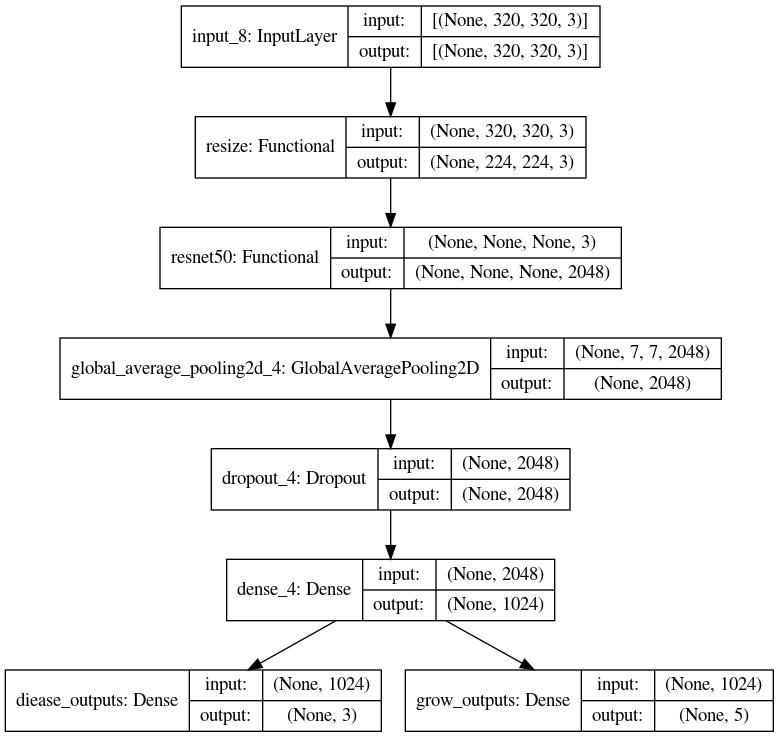

In [51]:
keras.utils.plot_model(model, show_shapes=True)

In [52]:
model.compile(loss={
                  'diease_outputs' : 'sparse_categorical_crossentropy',
                  'grow_outputs' : 'sparse_categorical_crossentropy'
              },
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy']) # 필요시 f1 score metrics custom

In [53]:
with tf.device("/cpu:0"):
    model.fit(train_generator,
          validation_data=valid_generator,
          verbose=1,
          epochs=10,
          steps_per_epoch=len(train_df)//BATCH_SIZE)

Epoch 1/10


2022-06-14 16:20:42.690545: W tensorflow/core/framework/op_kernel.cc:1763] OP_REQUIRES failed at sparse_xent_op.cc:90 : Invalid argument: Received a label value of 4 which is outside the valid range of [0, 3).  Label values: 0 0 0 3 2 0 0 0 3 1 0 1 3 3 0 0 0 1 0 0 1 0 0 0 0 3 0 3 0 1 3 0 2 0 1 3 1 4 2 1 0 2 1 1 0 3 0 0 0 3


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  Received a label value of 4 which is outside the valid range of [0, 3).  Label values: 0 0 0 3 2 0 0 0 3 1 0 1 3 3 0 0 0 1 0 0 1 0 0 0 0 3 0 3 0 1 3 0 2 0 1 3 1 4 2 1 0 2 1 1 0 3 0 0 0 3
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at tmp/ipykernel_3662/969837036.py:2) ]]
	 [[Mul_2/_2]]
  (1) Invalid argument:  Received a label value of 4 which is outside the valid range of [0, 3).  Label values: 0 0 0 3 2 0 0 0 3 1 0 1 3 3 0 0 0 1 0 0 1 0 0 0 0 3 0 3 0 1 3 0 2 0 1 3 1 4 2 1 0 2 1 1 0 3 0 0 0 3
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at tmp/ipykernel_3662/969837036.py:2) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_27811]

Function call stack:
train_function -> train_function
